In [1]:
import numpy as np
import timeit
import os
import pickle
from collections import namedtuple
from PIL import Image, ImageDraw

%run utils.ipynb
%run kernel_genetics.ipynb

In [2]:
KernelStats = namedtuple('KernelStats', 'complexity match_invokes match_invokes_success match_success_rate match_score')

class Kernel:
    def __init__(self, size):
        super()
        self.genotype = KernelGenotype()
        self.size = size
        self.m = []
        self.m_ones = 0
        # stats
        self.match_invokes = 0
        self.match_invokes_success = 0
        self.match_score = 0
    
    def __eq__(self, other): 
        if not isinstance(other, Kernel):
            return NotImplemented

        return self.genotype == other.genotype and self.size == other.size and np.array_equal(self.m, other.m) and self.m_ones == other.m_ones

    @classmethod
    def random_nog(cls, size, initial_complexity):
        k = cls(size)
        assert k.size >= 2
        assert initial_complexity >= 0 and initial_complexity <= 1

        k.m = np.uint8(np.random.uniform(size=(k.size, k.size)) <= initial_complexity)
        k.m_ones = k.compute_ones()

        if k.m_ones == 0:
            # complete blank mask was generated. Put random pixel somewhere
            random_pos = np.random.randint(k.size, size=(2,))
            k.m[random_pos[0], random_pos[1]] = 1
            k.m_ones = k.compute_ones()
            assert k.m_ones == 1
            
        return k

    @classmethod
    def solid_nog(cls, size, solid_value):
        assert solid_value in [0, 1]
        
        k = cls(size)
        k.m = np.full((k.size, k.size), solid_value, dtype=np.uint8)
        k.m_ones = k.compute_ones()
        return k

    @classmethod
    def from_m_data_nog(cls, m_data):
        assert len(m_data.shape) == 2
        assert m_data.shape[0] == m_data.shape[1]
        assert m_data.shape[0] > 0
        
        k = cls(m_data.shape[0])
        k.m = m_data
        k.m_ones = k.compute_ones()
        return k

    @classmethod
    def random(cls, size):
        assert size >= 2
        k = cls(size)
        k.genotype = KernelGenotype.random(1)
        k.m = k.genotype.build_phenotype(k.size)
        k.m_ones = k.compute_ones()
        return k

    def spawn_child(self):
        k = type(self)(self.size)
        k.genotype = self.genotype.mutated()
        k.m = k.genotype.build_phenotype(k.size)
        k.m_ones = k.compute_ones()
        return k

    def compute_ones(self):
        rv = 0
        # direct iteration is simplier to handle than np.unique_counts
        # because output of the latter may be any of [0, 1], [0], [1], []
        for x in np.nditer(self.m): 
            rv += (x == 1)

        return rv

    def get_complexity(self):
        assert self.size > 0
        return self.m_ones / (self.size * self.size)

    def get_inverted(self):
        k = Kernel(self.size)
        k.m = self.m.copy()
        k.m = 1 - k.m
        k.m_ones = k.compute_ones()
        return k

    # image is expected to be in grayscale mode, be it a PIL Image or just a 2d array
    # i.e. each pixel has to be 0..255
    def match(self, image, match_threshold, precomputed_pulp=None):
        assert isinstance(image, Image.Image) or isinstance(image, np.ndarray)
        assert not isinstance(image, Image.Image) or image.mode == 'L'
        assert not isinstance(image, np.ndarray) or(len(image.shape) == 2 and image.shape[0] == image.shape[1] and image.dtype == np.uint8)
        assert match_threshold > 0 and match_threshold <= 1
        self.match_invokes += 1

        # empty phenotype
        if not self.m_ones: 
            return False, 0

        pulp = precomputed_pulp
        
        if pulp is None:
            # PIL.Image.Image implements __array_interface__, 
            # so it's straightforward to pass image to np.einsum directly
            # otherwise we have just bytes in form of numpy array
            pulp = self.compute_match_pulp(image)

        match_score_relative = 0
        
        if self.m_ones > 0:
            denom = self.m_ones
            denom *= 255 # width of grayscale image
            match_score_relative = pulp / denom

        is_match = match_score_relative > match_threshold
        self.match_invokes_success += int(is_match)
        self.match_score += pulp * int(is_match) # kind to ReLU
        return is_match, match_score_relative

    # самая мякотка вычислений ядра свёртки =)
    def compute_match_pulp(self, image):
        return self.compute_match_pulp_2(image) # variant with ravel is a little bit faster
        
    def compute_match_pulp_1(self, image):
        return np.einsum('ij,ij->', self.m, image, dtype=np.uint32)

    def compute_match_pulp_2(self, image):
        a = np.ravel(self.m).astype(np.uint32)
        b = np.ravel(image).astype(np.uint32)
        return np.dot(a, b)

    def reset_stats(self):
        self.match_invokes = 0
        self.match_invokes_success = 0
        self.match_score = 0

    def get_stats(self):
        return KernelStats(
            complexity=self.get_complexity(),
            match_invokes=self.match_invokes,
            match_invokes_success=self.match_invokes_success,
            match_success_rate=0 if self.match_invokes == 0 else self.match_invokes_success / self.match_invokes,
            match_score=self.match_score
        )

    def to_image(self, inverted=True):
        sz = (self.size, self.size)
        bts = self.m.ravel() # 2d -> 1d

        if inverted:
            bts = 1 - bts # invert 0 -> 1 / 1-> 0
            
        bts = np.packbits(bts) # uint8 -> 1 bit
        return Image.frombytes('1', size=sz, data=bts)

In [3]:
my_config = Config()
k = Kernel.random_nog(my_config.kernel_size, 0.5)
image = Image.new('L', (my_config.kernel_size, my_config.kernel_size), 255)
%timeit -n10000 k.compute_match_pulp_1(image)
%timeit -n10000 k.compute_match_pulp_2(image)
assert k.compute_match_pulp_1(image) == k.compute_match_pulp_2(image)
k.compute_match_pulp_1(image), k.compute_match_pulp_2(image)

4.61 μs ± 67.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.8 μs ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


(np.uint32(133110), np.uint32(133110))

In [4]:
my_config = Config()
ones_kernel = Kernel.solid_nog(my_config.kernel_size, 1)
zeros_kernel = Kernel.solid_nog(my_config.kernel_size, 0)
assert ones_kernel != zeros_kernel
assert ones_kernel == Kernel.solid_nog(my_config.kernel_size, 1)
assert zeros_kernel == Kernel.solid_nog(my_config.kernel_size, 0)


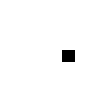
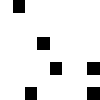
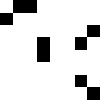
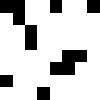
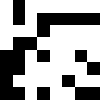
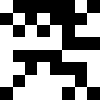
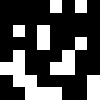
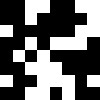
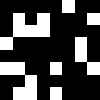
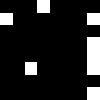
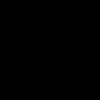

In [5]:
my_config = Config()
my_config.kernel_size = 8
kimgs = []
kimgcaps = dict()

for cmplx in range(0, 10 + 1):
    k = Kernel.random_nog(my_config.kernel_size, cmplx / 10)
    kimg = k.to_image().resize((100, 100))
    kimgs.append(kimg)
    kimgcaps[id(kimg)] = f'Complexity {cmplx} / {k.get_complexity()}'

display_images(kimgs, kimgcaps)

In [6]:
my_config = Config()

for i in range(2, 32):
    k = Kernel.random_nog(i, 0.5)
    is_match, match_score = k.match(k.m * 255, my_config.kernel_match_threshold)
    assert is_match
    assert match_score == 1, f'ks={i}, k.m={k.m}'

    invk = k.get_inverted()
    is_match, match_score_inv = k.match(invk.m * 255, my_config.kernel_match_threshold)
    assert not is_match
    assert match_score_inv == 0

In [7]:
my_config = Config()
k = Kernel.random_nog(my_config.kernel_size, 0.5)
run_counts = 10

for i in range(run_counts):
    is_match, match_score = k.match(k.m * 255, my_config.kernel_match_threshold)
    assert is_match
    assert match_score == 1, f'ks={i}, k.m={k.m}'

assert k.match_invokes == run_counts
assert k.match_invokes_success == run_counts, k.match_invokes_success
k.reset_stats()
assert k.match_invokes == 0
assert k.match_invokes_success == 0

k.match(k.m * 255, my_config.kernel_match_threshold)
assert k.match_invokes == 1
assert k.match_invokes_success == 1

my_config.kernel_size = 8 
half_fill_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(half_fill_image)
draw.rectangle([0, 0, 3, 7], 255)
k = Kernel.solid_nog(my_config.kernel_size, 1)
is_match, match_score = k.match(half_fill_image, 0.49)
assert is_match
assert match_score == 0.5, match_score

is_match, match_score = k.match(half_fill_image, 0.5)
assert not is_match
assert match_score == 0.5, match_score

In [8]:
my_config = Config()
my_config.kernel_size = 8 
k = Kernel.solid_nog(my_config.kernel_size, 1)

is_match, match_score = k.match(Image.new('L', (8, 8), 255), 0.99)
assert is_match 
assert match_score == 1
assert k.get_stats().match_score == 8 * 8 * 255, k.get_stats()

is_match, match_score = k.match(Image.new('L', (8, 8), 0), 0.01)
assert not is_match 
assert match_score == 0

is_match, match_score = k.match(np.full((8, 8), 255, dtype=np.uint8), 0.99)
assert is_match 
assert match_score == 1

is_match, match_score = k.match(np.zeros((8, 8), dtype=np.uint8), 0.01)
assert not is_match 
assert match_score == 0

k = Kernel.solid_nog(my_config.kernel_size, 0)
is_match, match_score = k.match(Image.new('L', (8, 8), 255), 0.99)
assert not is_match 
assert match_score == 0
assert k.get_stats().match_score == 0, k.get_stats()


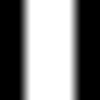
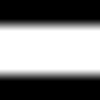
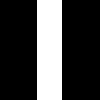
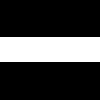
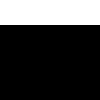
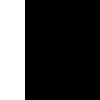

In [9]:
my_config = Config()
horz_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(horz_line_image)
draw.rectangle([0, 2, 7, 5], 255)

vert_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(vert_line_image)
draw.rectangle([2, 0, 5, 7], 255)

m_data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.uint8)

horz_line_kernel = Kernel.from_m_data_nog(m_data)
shifted_horz_line_kernel = Kernel.from_m_data_nog(np.roll(m_data, -3, axis=0))
vert_line_kernel = Kernel.from_m_data_nog(m_data.T)
shifted_vert_line_kernel = Kernel.from_m_data_nog(np.roll(m_data.T, -3, axis=1))

for i in range(10):
    match_score_relative = horz_line_kernel.match(horz_line_image, my_config.kernel_match_threshold)[1]
    assert match_score_relative == 1
    assert horz_line_kernel.get_stats().match_score == (i + 1) * 8 * 2 * 255
    assert horz_line_kernel.get_stats().match_invokes == (i + 1)
    assert horz_line_kernel.get_stats().match_invokes_success == (i + 1)

for i in range(10):
    match_score_relative = vert_line_kernel.match(vert_line_image, my_config.kernel_match_threshold)[1]
    assert match_score_relative == 1
    assert vert_line_kernel.get_stats().match_score == (i + 1) * 8 * 2 * 255
    assert vert_line_kernel.get_stats().match_invokes == (i + 1)
    assert vert_line_kernel.get_stats().match_invokes_success == (i + 1)

assert shifted_horz_line_kernel.match(horz_line_image, my_config.kernel_match_threshold)[1] == 0
assert shifted_horz_line_kernel.get_stats().match_score == 0
assert shifted_vert_line_kernel.match(vert_line_image, my_config.kernel_match_threshold)[1] == 0
assert shifted_vert_line_kernel.get_stats().match_score == 0

display_images(
    [vert_line_image.resize((100, 100)), 
     horz_line_image.resize((100, 100)), 
     vert_line_kernel.to_image(inverted=False).resize((100, 100)),
     horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_vert_line_kernel.to_image(inverted=False).resize((100, 100)),
    ]
)

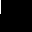

In [10]:
my_config = Config()
k = Kernel.random(my_config.kernel_size)
k.to_image(inverted=False)

In [11]:
m_data = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
], dtype=np.uint8)
kernels = [
    Kernel.from_m_data_nog(m_data), 
    Kernel.from_m_data_nog(m_data.T),
    Kernel.from_m_data_nog(np.roll(m_data, 4, axis=1)), 
    Kernel.from_m_data_nog(np.roll(m_data.T, 4, axis=0))
]
vert_bar_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(vert_bar_image)
draw.rectangle([0, 0, 3, 7], 255)

assert kernels[0].match(vert_bar_image, 0.5)[1] == 1
assert kernels[1].match(vert_bar_image, 0.5)[1] == 0.5
assert kernels[2].match(vert_bar_image, 0.5)[1] == 0
assert kernels[3].match(vert_bar_image, 0.5)[1] == 0.5


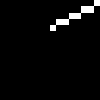
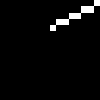

In [12]:
my_config = Config()
my_config.kernel_size = 16
k = Kernel.random(my_config.kernel_size)
k_child = k.spawn_child()
display_images(
    [k.to_image(inverted=False).resize((100, 100)), 
     k_child.to_image(inverted=False).resize((100, 100)), 
    ]
)